# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding  to  a  total  of  79354  contacts.  During  these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact,  a  large  number  of  attributes  was  stored  (e.g.  see Table  2)  and  if  there  was  a  success  (the  target  variable). For the whole database considered, there were 6499 successes (8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import auc as skl_auc, RocCurveDisplay, roc_curve


import timeit, time

import warnings
warnings.filterwarnings('ignore')


In [2]:
deposits_df = pd.read_csv('/Users/stephenscheiman/Library/Mobile Documents/com~apple~CloudDocs/Berkeley ML-AI/graded/module17_starter/assignment_17_repo/data/bank-additional-full.csv', sep = ';')

In [3]:
deposits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



While there is no missing data, a substantial number of rows have "unknown" as a value for one or more categories. Model runs with these rows dropped made model accuracy worse, so leaving them as is. We'll convert the target variable to an integer and one hot encode and scale the input variables. The metadata above says to drop the duration column, I found that doing so significantly decreased the accuracy of my models.

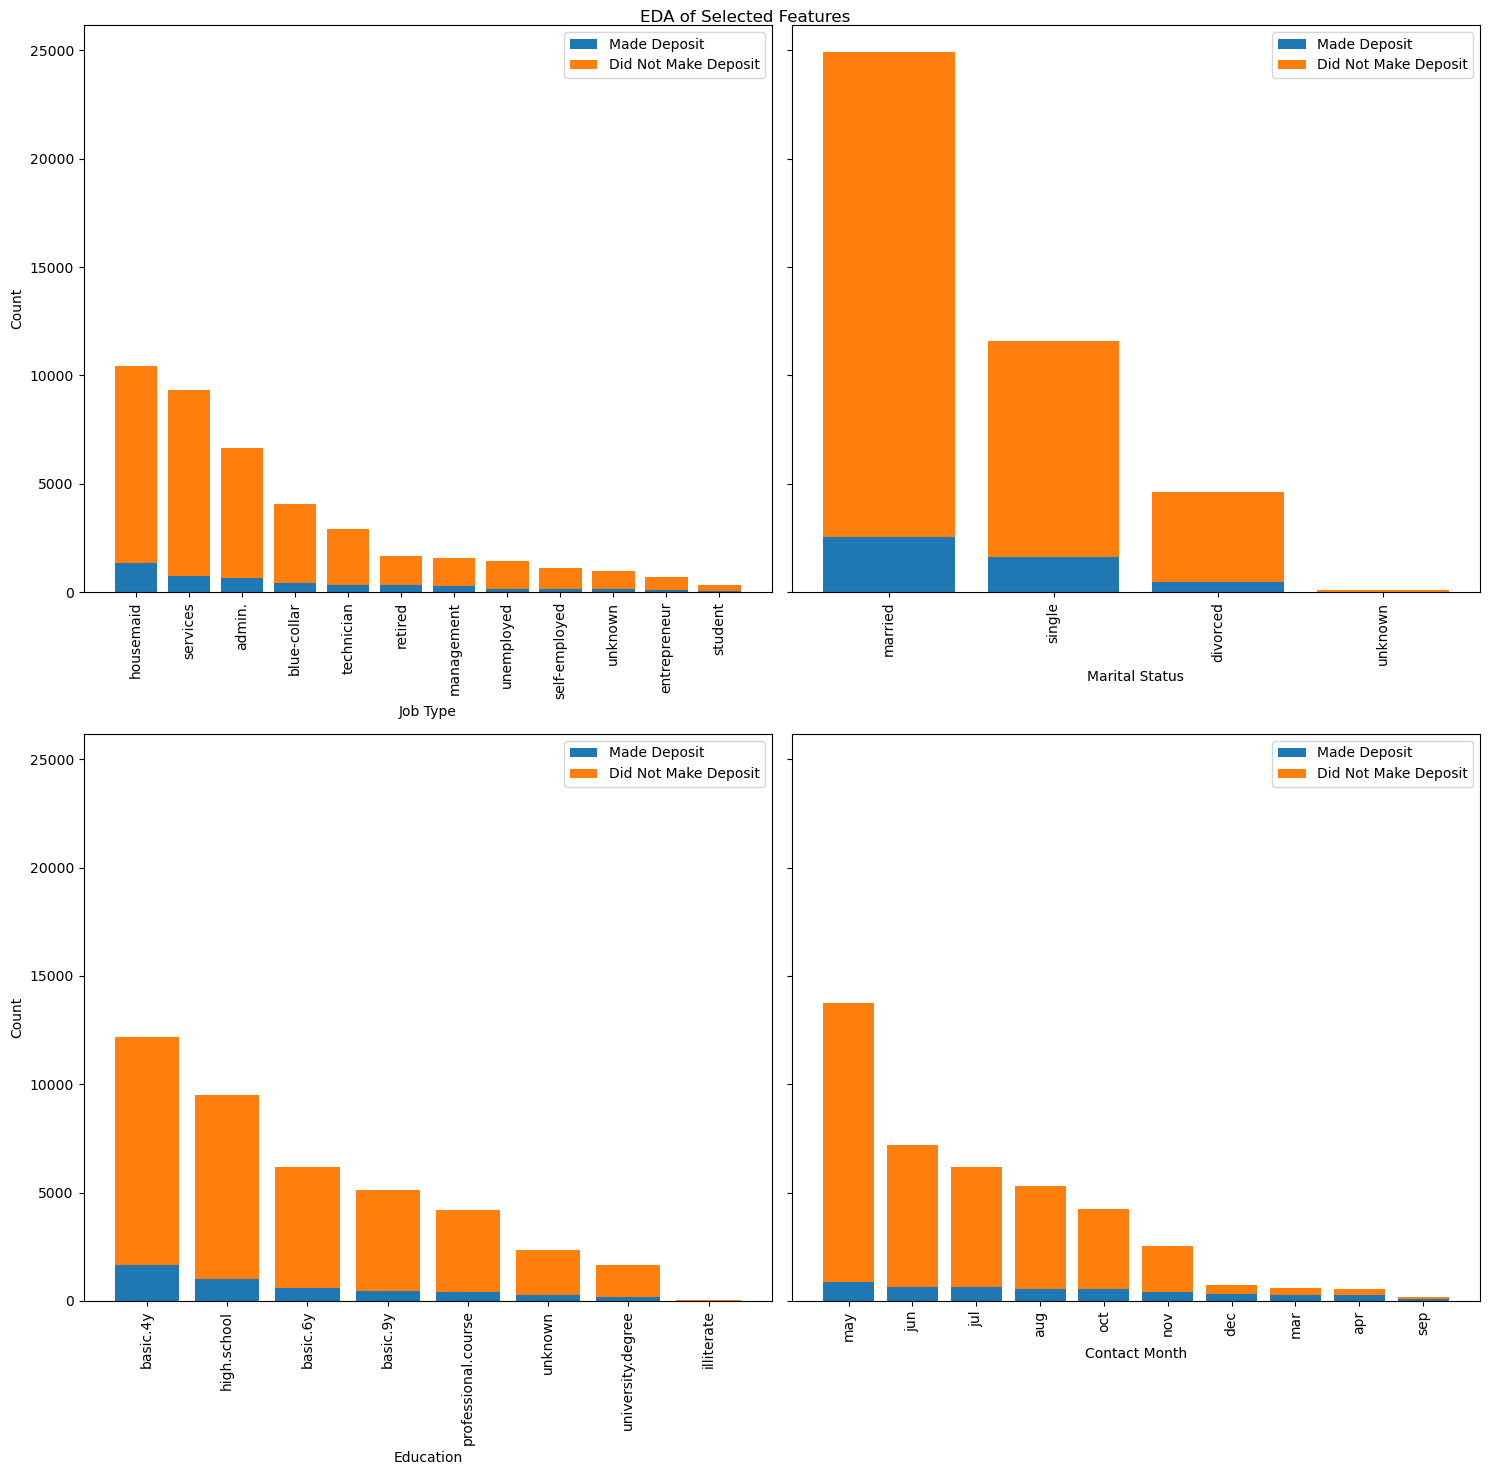

In [4]:
fig, axs = plt.subplots(2, 2, figsize= (15, 15), sharey= True)


deps = {
    'Made Deposit':deposits_df['job'][deposits_df.y == 'yes'].value_counts(),
    'Did Not Make Deposit':deposits_df['job'][deposits_df.y == 'no'].value_counts()
}
bottom = 0
for boolean, deps in deps.items():
    axs[0,0].bar(x= deposits_df['job'].unique(), height= deps, label=boolean, bottom=bottom)
    bottom += deps
axs[0,0].set_xticklabels(deposits_df['job'].unique(), rotation= 90)
axs[0,0].set_xlabel('Job Type')
axs[0,0].set_ylabel('Count')
axs[0,0].legend()

deps = {
    'Made Deposit':deposits_df['marital'][deposits_df.y == 'yes'].value_counts(),
    'Did Not Make Deposit':deposits_df['marital'][deposits_df.y == 'no'].value_counts()
}
bottom = 0
for boolean, deps in deps.items():
    axs[0,1].bar(x= deposits_df['marital'].unique(), height= deps, label=boolean, bottom=bottom)
    bottom += deps
axs[0,1].set_xticklabels(deposits_df['marital'].unique(), rotation= 90)
axs[0,1].set_xlabel('Marital Status')
axs[0,1].legend()

deps = {
    'Made Deposit':deposits_df['education'][deposits_df.y == 'yes'].value_counts(),
    'Did Not Make Deposit':deposits_df['education'][deposits_df.y == 'no'].value_counts()
}
bottom = 0
for boolean, deps in deps.items():
    axs[1,0].bar(x= deposits_df['education'].unique(), height= deps, label=boolean, bottom=bottom)
    bottom += deps
axs[1,0].set_xticklabels(deposits_df['education'].unique(), rotation= 90)
axs[1,0].set_xlabel('Education')
axs[1,0].set_ylabel('Count')
axs[1,0].legend()

deps = {
    'Made Deposit':deposits_df['month'][deposits_df.y == 'yes'].value_counts(),
    'Did Not Make Deposit':deposits_df['month'][deposits_df.y == 'no'].value_counts()
}
bottom = 0
for boolean, deps in deps.items():
    axs[1,1].bar(x= deposits_df['month'].unique(), height= deps, label=boolean, bottom=bottom)
    bottom += deps
axs[1,1].set_xticklabels(deposits_df['month'].unique(), rotation= 90)
axs[1,1].set_xlabel('Contact Month')
axs[1,1].legend()

fig.suptitle('EDA of Selected Features')
plt.tight_layout();


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective of this task is to enhance the efficiency of targeted campaigns for long-term deposit subscriptions by minimizing the number of customer contacts required.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [27]:
X = deposits_df.drop(columns=['y']) ## after several model runs with "duration" droppped as per the above, I keep it as we won't be using these models inferentially.

# transform target to integer
deposits_df.y.replace(['no', 'yes'], [0,1], inplace= True)

# ohe for categories, then scale entire dataframe
scaler = StandardScaler()
ohe = pd.get_dummies(X.select_dtypes(include='object')).join(X.select_dtypes(include='number'))
X = pd.DataFrame(scaler.fit_transform(ohe), columns=scaler.get_feature_names_out())

## below is for a dataframe that doesn't have the ohe columns scaled, an experiement that didn't make a material difference ##
# selector = make_column_selector(dtype_include='object')
# xformer = make_column_transformer((OneHotEncoder(drop='first'), selector), remainder=StandardScaler())
# X = pd.DataFrame(xformer.fit_transform(X), columns=xformer.get_feature_names_out())

y = deposits_df.y

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state= 42)

In [19]:
X_train

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39075,1.718146,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,-1.057857,-0.699197,0.156105,0.195414,1.671136,-1.961809,-1.490351,1.621083,-1.679109,-1.986638
34855,-0.582023,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,2.260146,...,-1.057857,-0.949895,0.517118,0.195414,-0.349494,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281
7107,-0.582023,1.857642,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,0.477486,0.072182,-0.204909,0.195414,-0.349494,0.648092,0.722722,0.886447,0.714190,0.331680
31614,-0.582023,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,3.062258,-0.147327,-0.442449,...,-0.578062,-0.726195,-0.565922,0.195414,1.671136,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281
34878,1.718146,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,-0.769980,3.558812,2.322186,0.195414,-0.349494,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,-0.582023,-0.538317,-0.19143,-0.162528,-0.276435,4.790252,-0.189032,-0.326556,-0.147327,-0.442449,...,1.724952,0.650716,-0.204909,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
11284,-0.582023,-0.538317,-0.19143,-0.162528,3.617483,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,-0.290186,0.114608,-0.565922,0.195414,-0.349494,0.839061,1.536429,-0.280328,0.772422,0.845170
38158,1.718146,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,-0.482104,-0.247940,-0.565922,-5.128043,1.671136,-2.216433,-1.977538,2.939106,-1.653164,-2.069683
860,-0.582023,-0.538317,-0.19143,-0.162528,3.617483,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,...,-0.002309,0.141606,-0.204909,0.195414,-0.349494,0.648092,0.722722,0.886447,0.711883,0.331680


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [14]:
y.value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

A model that simply guessed "No" would be correct 89% of the time. This is our target to beat.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [15]:
lgr = LogisticRegression()

start = time.process_time()

lgr.fit(X_train, y_train)

end = time.process_time()

lgr_train_acc = lgr.score(X_train, y_train)
lgr_test_acc = lgr.score(X_test, y_test)
lgr_fit_time = end - start

### Problem 9: Score the Model

What is the accuracy of your model?

In [20]:
lgr.score(X_test, y_test)

0.9122764425022255

Better than just guessing 'No'.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [21]:
knn = KNeighborsClassifier()

start = time.process_time()

knn.fit(X_train, y_train)

end = time.process_time()

knn_train_acc = knn.score(X_train, y_train)
knn_test_acc = knn.score(X_test, y_test)
knn_fit_time = end - start

In [22]:
dtc = DecisionTreeClassifier()

start = time.process_time()

dtc.fit(X_train, y_train)

end = time.process_time()

dtc_train_acc = dtc.score(X_train, y_train)
dtc_test_acc = dtc.score(X_test, y_test)
dtc_fit_time = end - start

In [23]:
svm = SVC()

start = time.process_time()

svm.fit(X_train, y_train)

end = time.process_time()

svm_train_acc = svm.score(X_train, y_train)
svm_test_acc = svm.score(X_test, y_test)
svm_fit_time = end - start

In [24]:
perf_df = pd.DataFrame({'Model':['Logistic Regression', 'K Nearest Neighbors','Decision Tree Classifier','Support Vector Model'], 
                        'Train Time':[lgr_fit_time, knn_fit_time, dtc_fit_time, svm_fit_time], 'Train Accuracy':[lgr_train_acc, knn_train_acc, dtc_train_acc, dtc_train_acc], 
                        'Test Accuracy':[lgr_test_acc, knn_test_acc, dtc_test_acc, svm_test_acc]})

In [25]:
perf_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.946940,0.911692,0.912276
1,K Nearest Neighbors,0.011735,0.917970,0.899247
2,Decision Tree Classifier,0.162932,1.000000,0.888241
3,Support Vector Model,8.512802,1.000000,0.910334


All models with the exception of default DTC are just slightly better than guessing "no". 

What about a model that only looks at scaled, numeric data and ignores categorical data?

In [26]:
tmp_X = deposits_df.select_dtypes(include='number').drop(columns='duration')
num_df = pd.DataFrame(scaler.fit_transform(tmp_X), columns=scaler.get_feature_names_out())
num_X = num_df.drop(columns= 'y')
num_X_train, num_X_test, num_y_train, num_y_test = train_test_split(num_X, y, test_size=0.30, random_state= 42)

num_lgr = LogisticRegression()
num_knn = KNeighborsClassifier()
num_dtc = DecisionTreeClassifier()
num_svm = SVC()

num_lgr.fit(num_X_train, num_y_train)
print(num_lgr.score(num_X_test, num_y_test))
num_knn.fit(num_X_train, num_y_train)
print(num_knn.score(num_X_test, num_y_test))
num_dtc.fit(num_X_train, num_y_train)
print(num_dtc.score(num_X_test, num_y_test))
num_svm.fit(num_X_train, num_y_train)
print(num_svm.score(num_X_test, num_y_test))

0.8989236869790402
0.8918022173666748
0.8712470664400744
0.8997329448895363


That doesn't really help. We'll keep the full categorical data.


#### Default Model Performance:

With default settings, Logisitic Regression provides the best accuracy with reasonable performance.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

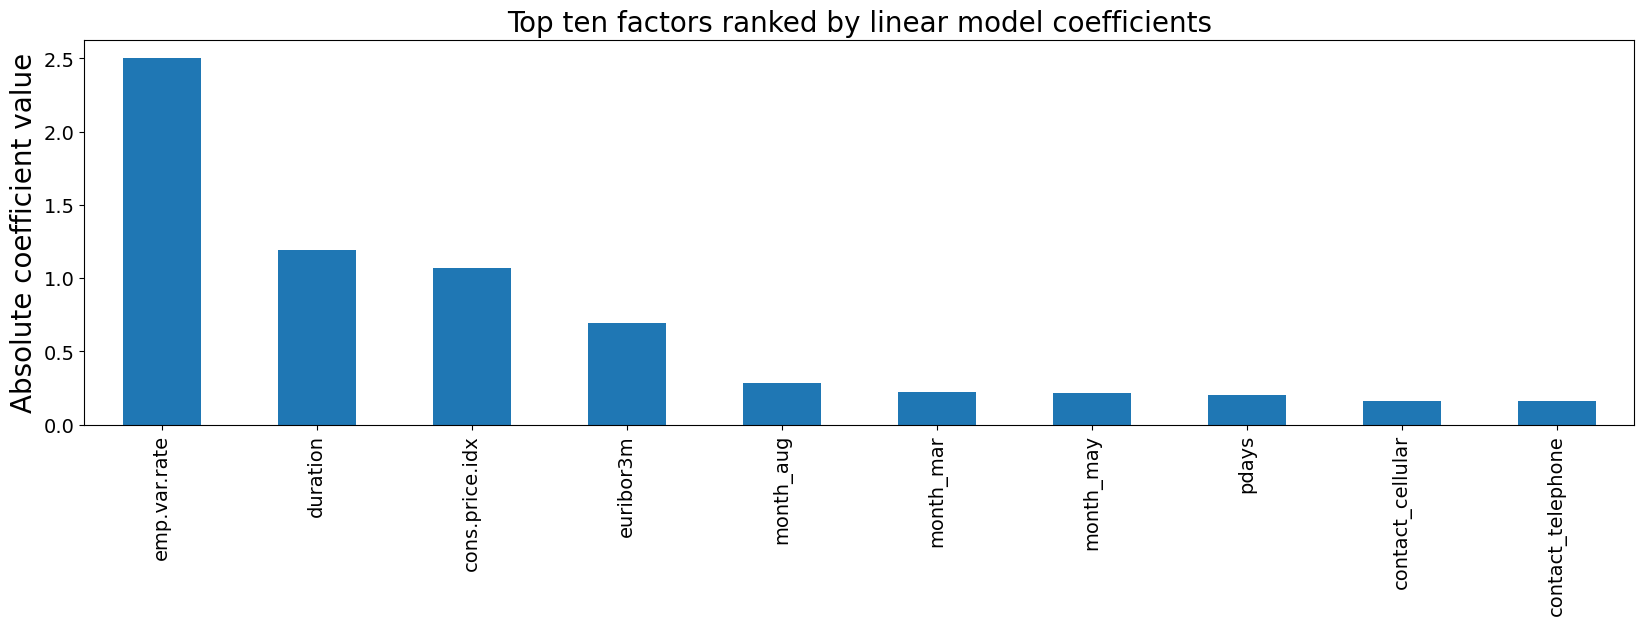

In [28]:
# Sort and visualize top ten features by influence on outcome
data = np.abs(lgr.coef_[0])
index = X_train.columns
importance = pd.Series(data=data, index=index)
importance.sort_values(inplace=True, ascending=False)
importance = importance[:10]
importance.plot.bar(figsize=(20,5), fontsize=14)
plt.title("Top ten factors ranked by linear model coefficients", fontsize=20)
plt.ylabel("Absolute coefficient value", fontsize=20)
plt.show();

Three of the five top factors influencing a deposit are macroeconomic in nature, suggesting that the outcome of a campaign mainly relies on factors beyond the control of the campaigner.

In [29]:
# Create polynomial features from num features, see if we can improve our numeric-only models
poly = PolynomialFeatures(degree=3, include_bias=False)
new_X_train = pd.DataFrame(poly.fit_transform(num_X_train), columns=poly.get_feature_names_out())
new_X_test = pd.DataFrame(poly.fit_transform(num_X_test), columns=poly.get_feature_names_out())


In [30]:
lgr = LogisticRegression()

start = time.process_time()

lgr.fit(new_X_train, y_train)

end = time.process_time()

lgr_train_acc = lgr.score(new_X_train, y_train)
lgr_test_acc = lgr.score(new_X_test, y_test)
lgr_fit_time = end - start

In [31]:
knn = KNeighborsClassifier()

start = time.process_time()

knn.fit(new_X_train, y_train)

end = time.process_time()

knn_train_acc = knn.score(new_X_train, y_train)
knn_test_acc = knn.score(new_X_test, y_test)
knn_fit_time = end - start

In [32]:
dtc = DecisionTreeClassifier()

start = time.process_time()

dtc.fit(new_X_train, y_train)

end = time.process_time()

dtc_train_acc = dtc.score(new_X_train, y_train)
dtc_test_acc = dtc.score(new_X_test, y_test)
dtc_fit_time = end - start

In [33]:
svm = SVC()

start = time.process_time()

svm.fit(new_X_train, y_train)

end = time.process_time()

svm_train_acc = svm.score(new_X_train, y_train)
svm_test_acc = svm.score(new_X_test, y_test)
svm_fit_time = end - start

In [34]:
iter2_perf_df = pd.DataFrame({'Model':['Logisitic Regression', 'K Nearest Neighbors','Decision Tree Classifier','Support Vector Model'], 
                        'Train Time':[lgr_fit_time, knn_fit_time, dtc_fit_time, svm_fit_time], 'Train Accuracy':[lgr_train_acc, knn_train_acc, dtc_train_acc, dtc_train_acc], 
                        'Test Accuracy':[lgr_test_acc, knn_test_acc, dtc_test_acc, svm_test_acc]})

In [35]:
iter2_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logisitic Regression,6.077077,0.898859,0.898357
1,K Nearest Neighbors,0.010338,0.912213,0.890022
2,Decision Tree Classifier,1.981475,0.957650,0.873270
3,Support Vector Model,18.445953,0.957650,0.899247


In [36]:
iter2_perf_df['Test Accuracy'] - perf_df['Test Accuracy']

0   -0.013919
1   -0.009226
2   -0.014971
3   -0.011087
Name: Test Accuracy, dtype: float64

No meaningful improvement to our model from Polynomial Features. We'll drop it and move forward with tuning our models with the standardized categorical and numeric data.

In [37]:
#Grid Search for parameter tuning
lgr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
lgr_grid = GridSearchCV(lgr, param_grid=lgr_params, cv= 5, scoring='accuracy').fit(X_train, y_train)


In [38]:
print(lgr_grid.best_params_)
print(lgr_grid.best_estimator_)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=1, penalty='l1', solver='liblinear')


In [39]:
lgr = LogisticRegression(C= 1, penalty= 'l1', solver= 'liblinear')

start = time.process_time()

lgr.fit(X_train, y_train)

end = time.process_time()

tuned_lgr_train_acc = lgr.score(X_train, y_train)
tuned_lgr_test_acc = lgr.score(X_test, y_test)
tuned_lgr_fit_time = end - start

print(lgr.score(X_test, y_test))

0.9121955167111758


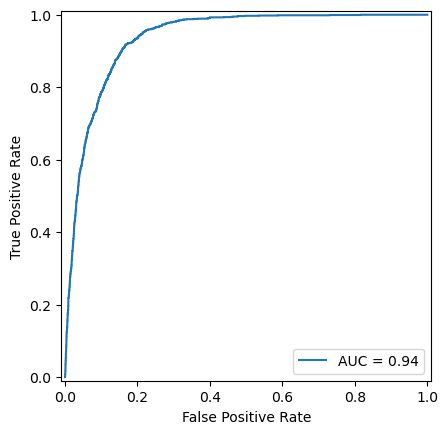

In [40]:
y_score = lgr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
roc.plot();

In [41]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_grid = GridSearchCV(knn, param_grid=knn_params, cv= 5, scoring='accuracy').fit(X_train, y_train)

In [42]:
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(metric='euclidean', n_neighbors=9)


In [43]:
knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 9, weights= 'uniform')

start = time.process_time()

knn.fit(X_train, y_train)

end = time.process_time()

tuned_knn_train_acc = knn.score(X_train, y_train)
tuned_knn_test_acc = knn.score(X_test, y_test)
tuned_knn_fit_time = end - start

print(knn.score(X_test, y_test))

0.8973860969490977


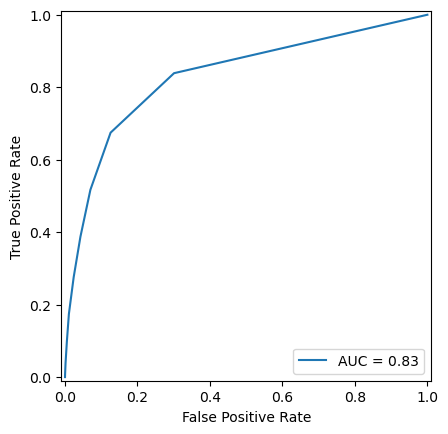

In [44]:
y_score = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
roc.plot();

In [45]:
dtc_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dtc_grid = GridSearchCV(dtc, param_grid=dtc_params, cv= 5, scoring='accuracy').fit(X_train, y_train)

In [46]:
print(dtc_grid.best_params_)
print(dtc_grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=5, min_samples_leaf=2)


In [47]:
dtc = DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf= 2, min_samples_split= 2)

start = time.process_time()

dtc.fit(X_train, y_train)

end = time.process_time()

tuned_dtc_train_acc = dtc.score(X_train, y_train)
tuned_dtc_test_acc = dtc.score(X_test, y_test)
tuned_dtc_fit_time = end - start

print(dtc.score(X_test, y_test))

0.9161608804726066


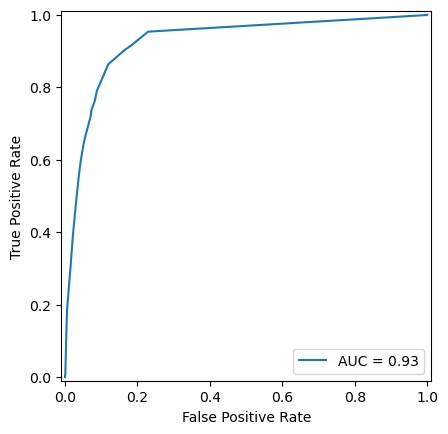

In [48]:
y_score = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
roc.plot();

In [49]:
svm_params = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf']
}
svm_grid = GridSearchCV(svm, param_grid=svm_params, cv= 5, scoring='accuracy').fit(X_train, y_train)

In [50]:
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1, gamma=0.01)


In [51]:
svm = SVC(C= 1, gamma= 0.01, kernel= 'rbf')

start = time.process_time()

svm.fit(X_train, y_train)

end = time.process_time()

tuned_svm_train_acc = svm.score(X_train, y_train)
tuned_svm_test_acc = svm.score(X_test, y_test)
tuned_svm_fit_time = end - start

print(svm.score(X_test, y_test))

0.9093631140244396


In [ ]:
y_score = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
roc.plot();

In [52]:
iter3_perf_df = pd.DataFrame({'Tuned Model':[lgr, knn, dtc, svm], 
                        'Tuned Train Time':[tuned_lgr_fit_time, tuned_knn_fit_time, tuned_dtc_fit_time, tuned_svm_fit_time], 'Tuned Train Accuracy':[tuned_lgr_train_acc, tuned_knn_train_acc, tuned_dtc_train_acc, tuned_dtc_train_acc], 
                        'Tuned Test Accuracy':[tuned_lgr_test_acc, tuned_knn_test_acc, tuned_dtc_test_acc, tuned_svm_test_acc]})

In [53]:
iter3_perf_df

,Tuned Model,Tuned Train Time,Tuned Train Accuracy,Tuned Test Accuracy
0,"LogisticRegression(C=1, penalty='l1', solver='...",3.991497,0.911727,0.912196
1,"KNeighborsClassifier(metric='euclidean', n_nei...",0.009842,0.908640,0.897386
2,"DecisionTreeClassifier(max_depth=5, min_sample...",0.067361,0.917415,0.916161
3,"SVC(C=1, gamma=0.01)",8.010745,0.917415,0.909363


In [56]:
comp_perf_df = perf_df.join(iter3_perf_df[['Tuned Train Time', 'Tuned Train Accuracy', 'Tuned Test Accuracy']])
comp_perf_df['Model Tuning Improvement'] = comp_perf_df['Tuned Test Accuracy'] - comp_perf_df['Test Accuracy']

In [58]:
comp_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy,Tuned Train Time,Tuned Train Accuracy,Tuned Test Accuracy,Model Tuning Improvement
0,Logistic Regression,0.946940,0.911692,0.912276,3.991497,0.911727,0.912196,-0.000081
1,K Nearest Neighbors,0.011735,0.917970,0.899247,0.009842,0.908640,0.897386,-0.001861
2,Decision Tree Classifier,0.162932,1.000000,0.888241,0.067361,0.917415,0.916161,0.027919
3,Support Vector Model,8.512802,1.000000,0.910334,8.010745,0.917415,0.909363,-0.000971


Grid search for hyperparameter tuning results in Decision Tree Classification having the best accuracy of all four models at 91.6%.

### Conclusions
To restate, the business objective of this task was to enhance the efficiency of targeted campaigns for long-term deposit subscriptions by minimizing the number of customer contacts required. Interestingly enough, I found that three of the five top factors that influenced whether or not a depoist was made were beyond the control of the campaigners. The employment variation rate, consumer price index, and the eurobor 3 month rate had the greatest influence on outcome based on their LR Coefficients. While our goal was to minimize the number of contacts required to get a deposit, the data supports multiple contacts being advantageous. For unknown reasons, March, May and August also seem to be the best months for getting a deposit so if our goal is to minimize contacts, *we should concentrate efforts to those months and when the macroeconomic indicators are favorable.* Keeping 'duration' in the dataset, while it made the models more accurate, is also of dubious value if one were to attempt to use these models inferentially.

By way of next steps, because of the imbalanced nature of the dataset, perhaps further study leveraging oversampling to balance the data might provide for a better model.